# Starbucks Capstone Challenge

### Project Overview

The Starbucks Capstone Challenge data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. Understanding our customers is the key providing them a good service and sustain a profitable business. To understand them well, we need to pay attention on their purchase behaviour. One way we can collect and analyse their purchasing behaviour through an app, then identify their needs based on demographics.

### Problem Statement

I will examine the data set and combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. In the following section I aim to:

1. Analyse customer characteristics and demographics
2. What offer should be sent to each customer based on their demographics?

### Project Metrics

I am planning to use an unsupervised machine learning model with K-Means is used to cluster the customers.

The number of clusters is choosed with SSE metrics :

1. The Silhouttee score)

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

2. The Inertia / Sum Square Error (SSE) value, can be recognized as a measure of how internally coherent clusters are. We seek to minimize the value.

After cluster is determined, different measurements can be used to determine which offer to be overweigh in each group. In practice, even if a group of customer show strong perferrence of a type offer, it is not a good practice to only send that offer and ignore other offers. Customer perferrence could change over the time and sometimes it is also important to influenece customer behaviors to acheive maximum results. The recommendation derived from the anlaysis can guide the markting group to decide which offer to overwieght in real case senarios, based on customer perferrence. Depends on the outcome of the analysis, I will most likely compare spend amount as an indicator of customer perference. I am using a simple assumption that the spend of the transaction shows the customer's perference of an offer. 

With a focus on the average transaction amount, I will consider the following metrix

The average transaction amount. If the experiment group has higher average transaction amount, the recommendation engine can be considered useful.
Percentage of offer completed. If the experiment group has higher percentage of offer completed, the recommendation engine can be considered useful.
Ratio of transaction from offer and offer received. The higher it is for the experiment group, the better.
Ratio of transaction not from offer and offer received. The lower it is for the experiment group, the better.


### Data Sets

The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

portfolio.json

id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) -
channels (list of strings)

profile.json

age (int) - age of the customer
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income

transcript.json

event (str) - record description (ie transaction, offer received, offer viewed, etc.)
person (str) - customer id
time (int) - time in hours. The data begins at time t=0
value - (dict of strings) - either an offer id or transaction amount depending on the record

### Link of the Blog Post
https://medium.com/@ygsunshine86/what-promotion-to-send-to-your-customer-hear-what-data-has-to-say-26506f8d2b72?sk=9578d1a12267eec4dbce0ef16bb373b3


### 1. Data ETL Pipeline

The following steps to load, extract and prepare data can be saved in a .py file and to import in the future analysis. In order to demonstrate the steps for this project, I am going to include it in the main submit file and save the results to .csv format. In the modeling step, I am going to impore the clean data to consume. 

In [392]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [393]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [394]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [395]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [436]:
transcript.shape

(306534, 4)

In [396]:
#Transcript has a 'value' field in data library format. I am going to extract the offer id from the 'value' field
trans_new=pd.concat([transcript.drop(['value'], axis=1),transcript['value'].apply(pd.Series)],axis=1)

In [397]:
trans_new.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [399]:
### The 'value' field was sperate to two fields 'offer id' and 'offer_id' because the variance of the names.
###clean the dataset to combine the two offer id columns
for i in trans_new[~trans_new.offer_id.isnull()]:
    trans_new['offer id']=trans_new['offer_id']

In [82]:
#check if there is any duplicated rows in transcript: 397 duplicated values 
#(After checking, no duplicates were found in profile dataframe and portfolio dataframe)
dup_trans=trans_new[trans_new.duplicated()]
len(dup_trans)
#Remove duplicated values but kept the first
trans_new=trans_new.drop_duplicates()
len(transcript)-len(trans_new)

397

In [83]:
trans_new.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,NaN,NaN


In [537]:
#Exploratary Analysis to check null value
#trans_new[trans_new['event']=='transaction'].isnull().sum()

event            0
person           0
time             0
offer id    138953
amount           0
offer_id    138953
reward      138953
dtype: int64

In [527]:
# export cleaned transacript to .csv format
trans_new.drop(columns='offer_id').to_csv('data/new_transcript.csv')

In [35]:
#portfolio clean up and export to .csv format

available_channels =['email', 'mobile', 'social', 'web']
for channel in available_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0) 

portfolio.drop('channels',axis=1).to_csv('data/new_portfolio.csv')

In [43]:
#profile clean up
profile['became_member_on']=pd.to_datetime(profile['became_member_on'],format='%Y%m%d', errors='coerce')

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


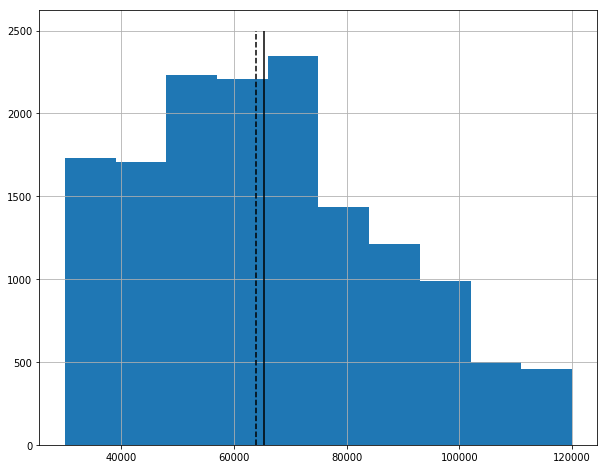

In [54]:
# What should be filled in for the null 
# The mean looks like it would be apropraiate in this distribution
profile.income.hist(bins=10, figsize=(10,8));
plt.vlines(profile.income.mean(), 0, 2500); # Show where the mean is in the chart
plt.vlines(profile.income.median(), 0, 2500, linestyles='dashed'); # Show where the median is in the chart

In [55]:
mean_val = profile.income.mean() # 65404.99
profile['income'].fillna(mean_val, inplace = True)

In [69]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [70]:
profile['gender'].fillna('Unknown', inplace = True)

In [71]:
profile.to_csv('data/new_profile.csv')

### 2. Import Cleaned Data

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc
from glob import glob
from tqdm import tqdm
import sys
sys.path.append(f'/home/{os.environ.get("USER")}/PythonLibrary')
from eda import EDA
%matplotlib inline

In [402]:
#read cleaned data in the dataframe
df_portfolio = pd.read_csv('data/new_portfolio.csv').drop(['Unnamed: 0'],axis=1)
df_profile = pd.read_csv('data/new_profile.csv').drop(['Unnamed: 0'],axis=1)
df_trans=pd.read_csv('data/new_transcript.csv').drop(['Unnamed: 0'],axis=1)
#df_profile['became_member_on']=pd.to_datetime(df_profile['became_member_on'],format='%Y%m%d', errors='coerce')
df_profile['became_member_on']=pd.to_datetime(df_profile['became_member_on'])

In [144]:
df_profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,Unknown,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,2018-07-12,Unknown,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,2017-08-04,Unknown,a03223e636434f42ac4c3df47e8bac43,65404.991568


In [104]:
df_profile.gender.unique()

array(['Unknown', 'F', 'M', 'O'], dtype=object)

### 3. Exploratory Data Analysis

I use python EDA package to quickly analyze the data set. 

Frist to look at the profile data set
1. The mean age is about 62. Age 18 to 45 only represents 25% of the customer base. The age of 118 looks like an outlier. However, this is a project dataset, we are lacking information how the data was collected. If we want to scrap the data further, we could make assumptions to cap the age data. For now, I decide to keep the data as is
2. There are unknown genders and O type of gender
3. Clearly there is correlation between age and income. The higher the age, the more income the group earns.
4. Time series analysis shows that in every year, subscriptions drop at the beginning of the year and then have a significant uprise right around July. I wonder if that is because people are signing up for their fall specials since that is around the time that the fall drinks go on display. Maybe the promotions are based around the fall drinks? One interesting thing to point is is that in even years, subsciptions seem to stay pretty constant, but in odd years, there are big jumps. Maybe there are new app releases in those years? 2018 also seems to be having a rough year. The summer months have had a big decrease in customer sign ups as opposes to the rate from previous years.

Preview of data:


,age,became_member_on,gender,id,income
0,118,2017-02-12,Unknown,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,2018-07-12,Unknown,38fe809add3b4fcf9315a9694bb96ff5,65404.991568



To check: 
 (1) Total number of entries 
 (2) Column types 
 (3) Any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              17000 non-null object
id                  17000 non-null object
income              17000 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB
None

No duplicated entries found

To check: 
Unique count of non-numeric data

gender        4
id        17000
dtype: int64
Top 5 unique values of gender
    gender  Count
0        M   8484
1        F   6129
2  Unknown   2175
3        O    212
 
Top 5 unique values of id
                                 id  Count
0  27345a9ee74f4ed08dc85495daafddc2      1
1  988cc778d73f461f9b7ef0c66f6b98ba      1
2  7f49a11dda5b44c2b6afb7d3303c2a88      1
3  9b12f30fa5ca48fca44b3ed7c7936749      1
4  6445de3b47274c759

,count,mean,std,min,25%,50%,75%,max
age,17000.0,62.531412,26.738580,18.0,45.0,58.000000,73.0,118.0
income,17000.0,65404.991568,20169.288288,30000.0,51000.0,65404.991568,76000.0,120000.0


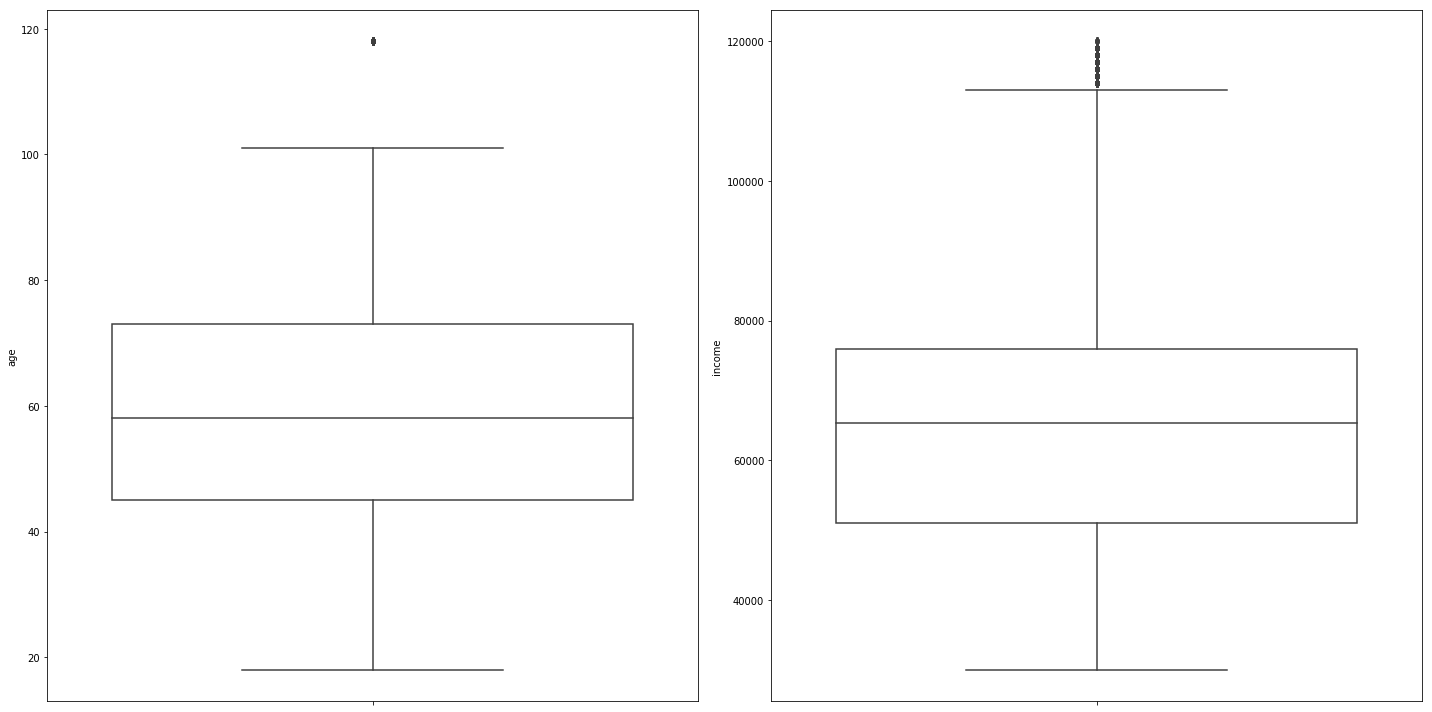


To check pairwise joint distribution of numeric data


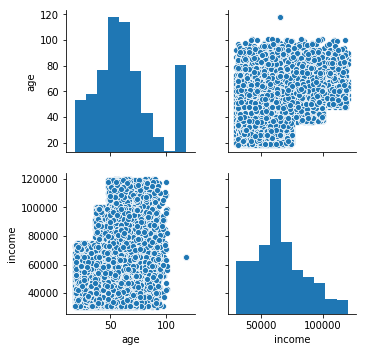


To check time series of numeric data  by daily, monthly and yearly frequency
Plotting daily data


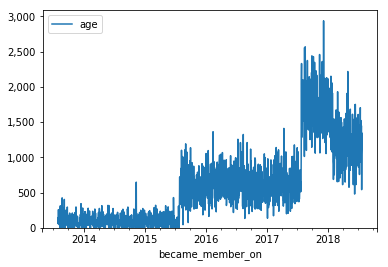

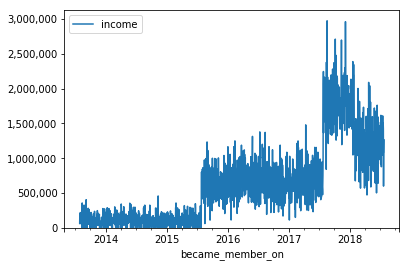

Plotting monthly data


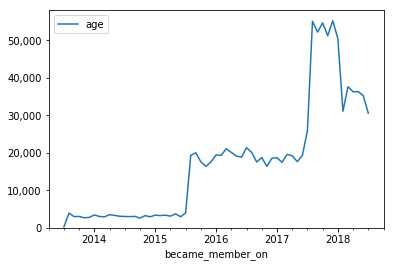

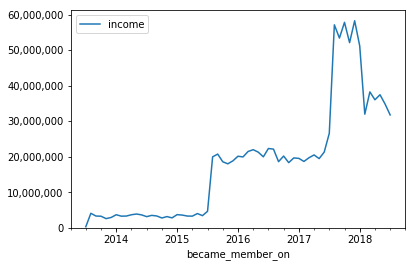

Plotting yearly data


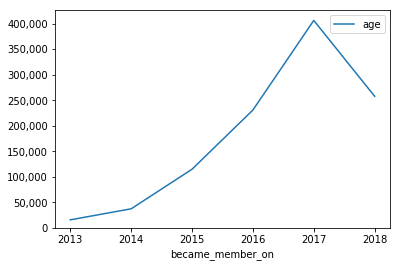

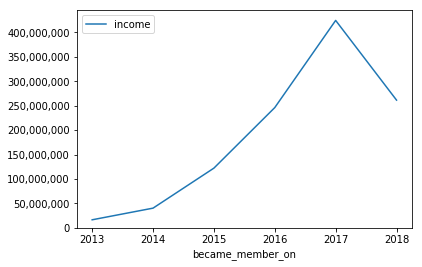

In [400]:
EDA(df_profile)

Roughly half of the people in the Starbucks population are males, while females, unknown, and other genders make up the rest of the population. When looking at the mean income of each gender, they aren't very different from each other, but looking at their distirubtions tell a different story. Unknown genders don't have a distribution to look at since they were all replaced with the mean income of the overall poopulation. Females have most of their users with incomes between 55,000 dollars to 90,000 dollars while males upper quartile of users have roughly the same income as the mean value for female customers, roughly 60,000 dollars

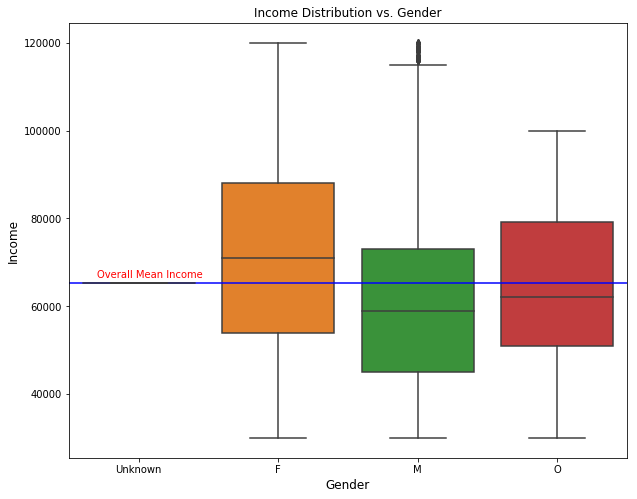

In [76]:
plt.figure(figsize=(10,8))
sns.boxplot(x = 'gender', y = 'income', data = profile)
plt.hlines(mean_val, -100 , 1000, color = 'b')
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.title('Income Distribution vs. Gender')
plt.text(x = -.3, y = mean_val + 1000, s = "Overall Mean Income", color = 'r');

In [105]:
df_trans.head()

,event,person,time,offer id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,NaN


In [106]:
df_portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [403]:
# Write a function to draw histograph of numeric features

def desc_num_feature(df, feature_name, bins=20, edgecolor='k', **kwargs):
    fig, ax = plt.subplots(figsize=(8,6))
    df[feature_name].hist(bins=bins, edgecolor=edgecolor, ax=ax, **kwargs)
    ax.set_title(feature_name, size=15)
    print(df[feature_name].describe().round(2))

In [404]:
#99.5% transaction amount is less than $55
len(df_trans[df_trans['amount']<55])/len(df_trans[df_trans['event']=='transaction'])

0.9953005692572309

count    138247.00
mean         11.22
std           9.61
min           0.05
25%           2.76
50%           8.80
75%          17.91
max          49.94
Name: amount, dtype: float64


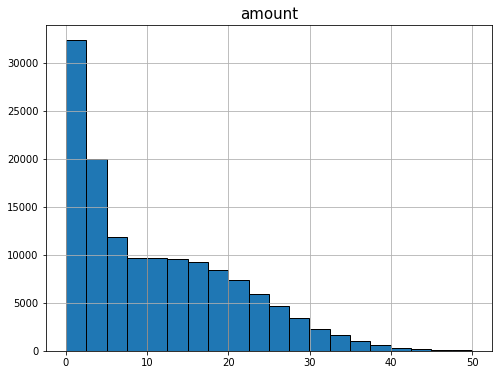

In [9]:
#Draw histgraph of $$ amount of spend
desc_num_feature(df_trans[df_trans['amount']<50],'amount')

The EDA of transcript shows us that Null value exist in the data set due to the way the data is collected. There are four even types need to encode. The joint distribution of numeric data shows some basic patterns but not too much.

Preview of data:


,event,person,time,offer id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,NaN



To check: 
 (1) Total number of entries 
 (2) Column types 
 (3) Any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306137 entries, 0 to 306136
Data columns (total 6 columns):
event       306137 non-null object
person      306137 non-null object
time        306137 non-null int64
offer id    33182 non-null object
amount      138953 non-null float64
reward      33182 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB
None

Preview of data with null values:


,event,person,time,offer id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,NaN


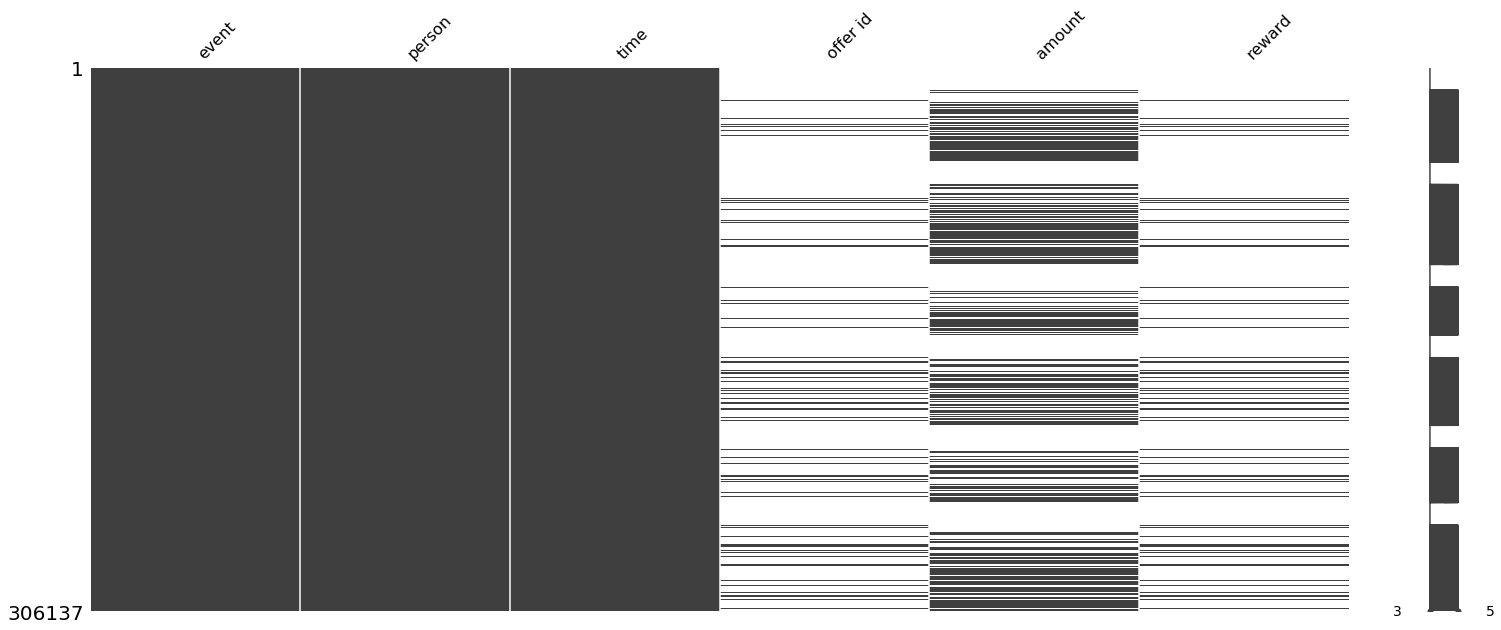


No duplicated entries found

To check: 
Unique count of non-numeric data

event           4
person      17000
offer id        8
dtype: int64
Top 5 unique values of event
             event   Count
0      transaction  138953
1   offer received   76277
2     offer viewed   57725
3  offer completed   33182
 
Top 5 unique values of person
                             person  Count
0  94de646f7b6041228ca7dec82adb97d2     51
1  8dbfa485249f409aa223a2130f40634a     49
2  79d9d4f86aca4bed9290350fb43817c2     48
3  5e60c6aa3b834e44b822ea43a3efea26     48
4  d0a80415b84c4df4908b8403b19765e3     47
 
Top 5 unique values of offer id
                           offer id  Count
0  fafdcd668e3743c1bb461111dcafc2a4   5265
1  2298d6c36e964ae4a3e7e9706d1fb8c2   5112
2  9b98b8c7a33c4b65b9aebfe6a799e6d9   4303
3  f19421c1d4aa40978ebb69ca19b0e20d   4262
4  2906b810c7d4411798c6938adc9daaa5   3964
 

To check: 
Distribution of numeric data


,count,mean,std,min,25%,50%,75%,max
time,306137.0,366.185015,200.348174,0.00,186.00,408.00,528.00,714.00
amount,138953.0,12.777356,30.250529,0.05,2.78,8.89,18.07,1062.28
reward,33182.0,4.902628,2.887201,2.00,2.00,5.00,5.00,10.00


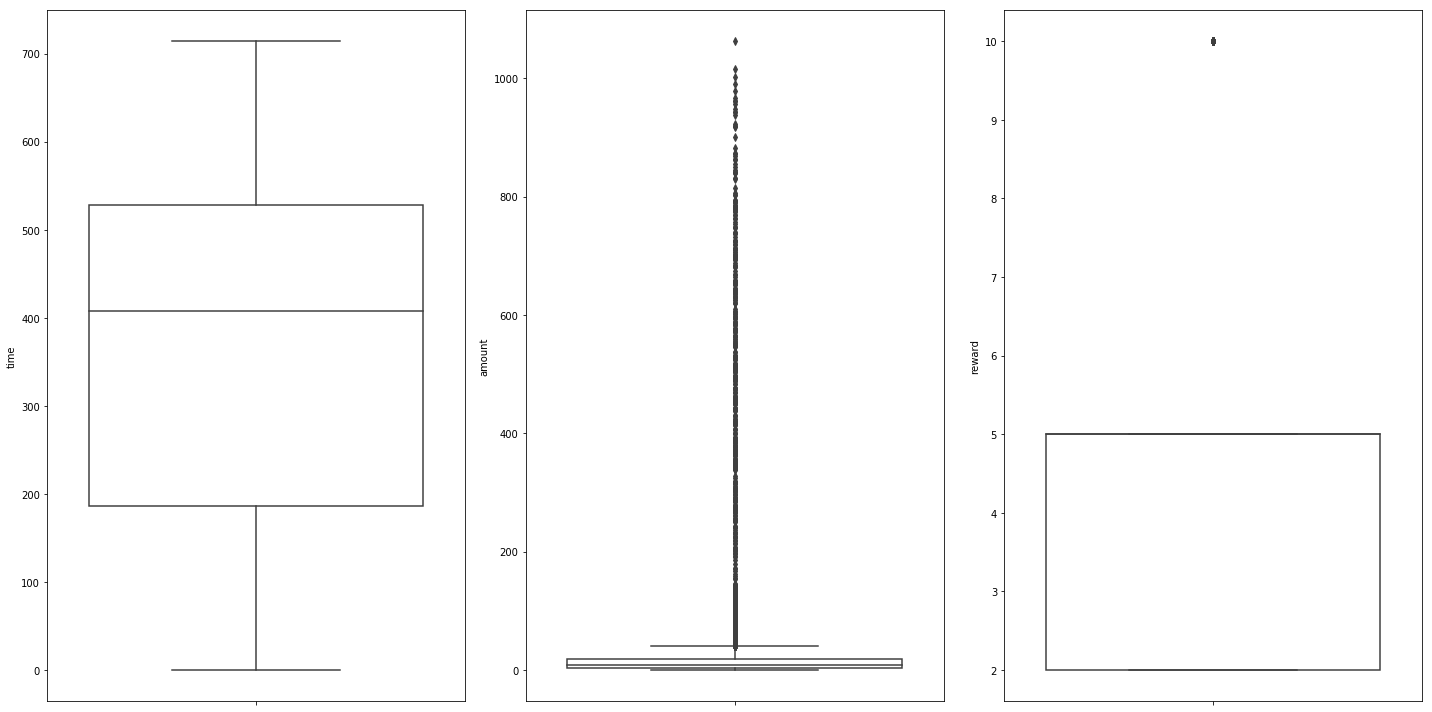


To check pairwise joint distribution of numeric data


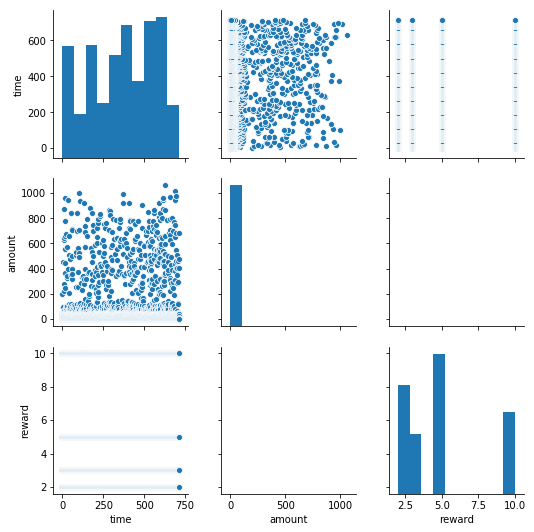


To check time series of numeric data  by daily, monthly and yearly frequency


In [15]:
EDA(df_trans)

In [405]:
# Create dummy variables for event types
df_trans_new=pd.get_dummies(df_trans,columns=["event"])
df_trans_new.head()

,person,time,offer id,amount,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,NaN,0,1,0,0


In [406]:
#Test
df_trans_new[df_trans_new['event_transaction']==1].head()


,person,time,offer id,amount,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
12654,02c083884c7d45b39cc68e1314fec56c,0,NaN,0.83,NaN,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,34.56,NaN,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,0,NaN,13.23,NaN,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,NaN,19.51,NaN,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,18.97,NaN,0,0,0,1


In [407]:
# Group by person to examine the spend pattern
df_trans_new.groupby('person').sum().head()


,time,amount,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction
person,,,,,,,
0009655768c64bdeb2e877511632db8f,9414,127.60,9.0,3,5,4,8
00116118485d4dfda04fdbaba9a87b5c,2814,4.09,0.0,0,2,2,3
0011e0d4e6b944f998e987f904e8c1e5,6570,79.46,13.0,3,5,5,5
0020c2b971eb4e9188eac86d93036a77,6378,196.86,14.0,3,5,3,8
0020ccbbb6d84e358d3414a3ff76cffd,8622,154.05,13.0,3,4,4,12


In [408]:
# Merge to create data frame for all customers
df_1=df_trans_new.merge(df_portfolio,how='left',left_on='offer id',right_on='id')
# df_1 has two categorical variables. We will create dummy variables
df_1=pd.get_dummies(df_1,columns=["offer_type"])

df_1.groupby('person').sum().merge(df_profile,how='left',left_on='person',right_on='id')
df_2=df_1.groupby('person').sum()

df_all_cust=df_2.merge(df_profile,how='left',left_on='person',right_on='id')
df_all_cust=df_all_cust.rename(columns={"id": "cus_id","reward_x":"reward"}).drop(columns=['reward_y'])
#df_1.offer_type.unique()
df_all_cust=pd.get_dummies(df_all_cust,columns=["gender"])

# Adding variables 1: avg_spend
#df_all_cust['avg_spend']=df_all_cust['amount']/df_all_cust['event_transaction']
#df_all_cust['offer_complete_rate']=df_all_cust['event_offer completed']/df_all_cust['event_offer viewed']
#df_all_cust['avg_spend'].fillna(0)
#df_all_cust['offer_complete_rate'].fillna(0)

# Drop variables "time" and "become_memeber_on" as they are less relavent in clustering
df_all_cust1=df_all_cust.drop(columns=['time','became_member_on','cus_id'])
df_all_cust1.head()


,amount,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,age,income,gender_F,gender_M,gender_O,gender_Unknown
0,127.60,9.0,3,5,4,8,25.0,22.0,3.0,3.0,2.0,3.0,1,2,33,72000.000000,0,1,0,0
1,4.09,0.0,0,2,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0,0,118,65404.991568,0,0,0,1
2,79.46,13.0,3,5,5,5,32.0,24.0,3.0,2.0,1.0,3.0,1,2,40,57000.000000,0,0,1,0
3,196.86,14.0,3,5,3,8,30.0,25.0,3.0,3.0,3.0,3.0,1,2,59,90000.000000,1,0,0,0
4,154.05,13.0,3,4,4,12,17.0,19.0,3.0,3.0,2.0,3.0,2,1,24,60000.000000,1,0,0,0


In [409]:
df_all_cust.isnull().sum()

time                     0
amount                   0
reward                   0
event_offer completed    0
event_offer received     0
event_offer viewed       0
event_transaction        0
difficulty               0
duration                 0
email                    0
mobile                   0
social                   0
web                      0
offer_type_bogo          0
offer_type_discount      0
age                      0
became_member_on         0
cus_id                   0
income                   0
gender_F                 0
gender_M                 0
gender_O                 0
gender_Unknown           0
dtype: int64

# Final Analyis

Now we have each customer in a dataframe with all of their personal characteristics, transactional aggregates, and promotional aggregates, one way that we can imporve on correct promotional affiliation is to see how the specific cluster responds to different promotions. 

In [439]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [411]:
scaler = MinMaxScaler()
print(scaler.fit(df_all_cust1))

MinMaxScaler(copy=True, feature_range=(0, 1))


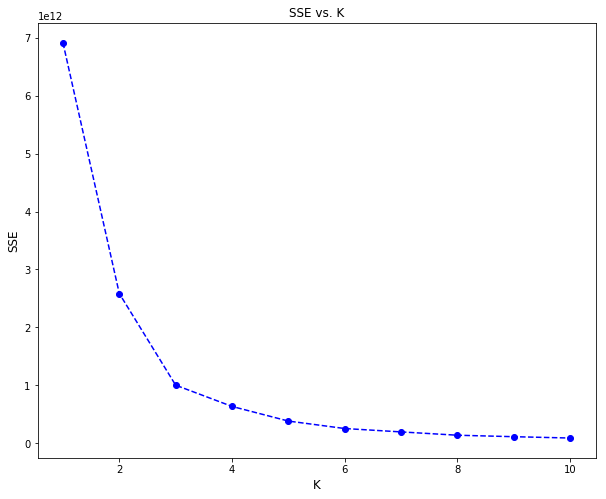

In [262]:
scores=[]

for k in range (1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(df_all_cust1)
    
    scores.append(abs(model.score(df_all_cust1)))
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize = 12);
plt.ylabel('SSE', fontsize = 12);
plt.title('SSE vs. K', fontsize = 12);

From the chart above we will pick 4 clussters 

In [412]:
clust = cluster.AgglomerativeClustering(4, linkage='ward')
df_all_cust1['Cluster4']=clust.fit_predict(df_all_cust1)

In [413]:
df_all_cust1.Cluster4.value_counts(normalize=True)

2    0.334941
1    0.260647
0    0.256176
3    0.148235
Name: Cluster4, dtype: float64

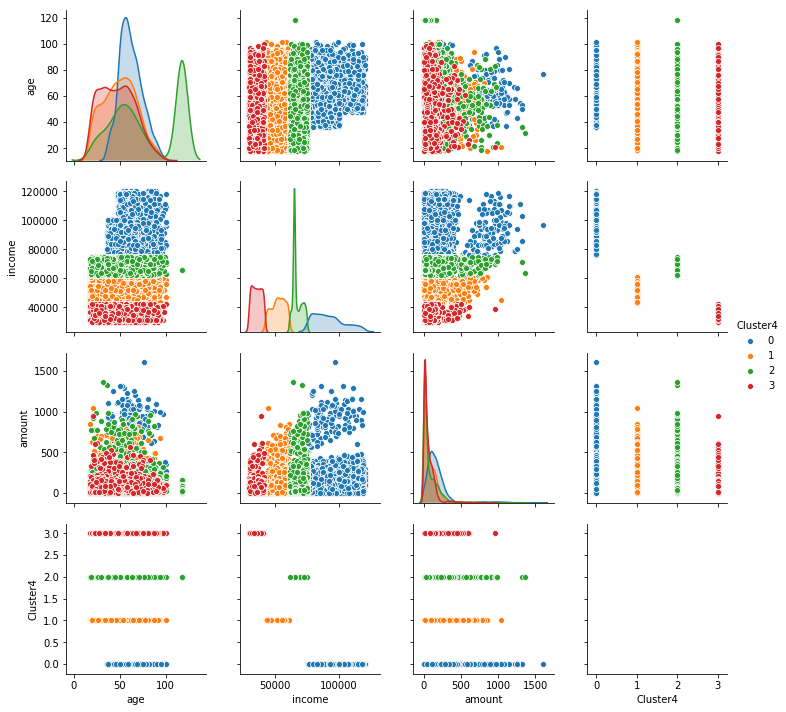

In [265]:
# Personal Demographics
visual_columns = ['age'
                  ,'income'
                  , 'amount'
                  ,'Cluster4']

sns_personal_attributes = sns.pairplot(df_all_cust1[visual_columns].fillna(0), hue='Cluster4');
sns_personal_attributes.savefig("personal_attributes_clusters.png")

<Figure size 1440x720 with 0 Axes>

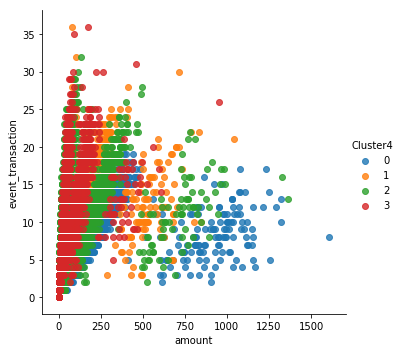

In [266]:
plt.figure(figsize = (20,10))
sns.lmplot(x='amount', y='event_transaction', hue='Cluster4'
           , data=df_all_cust1, fit_reg=False);

<Figure size 720x576 with 0 Axes>

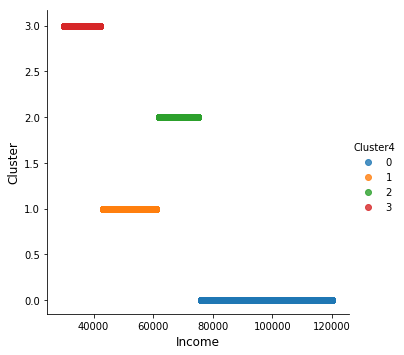

<Figure size 720x576 with 0 Axes>

In [267]:
# Cluster and income distirbution
# You can see that this really splits the distribution of income apart
sns.lmplot(x='income', y='Cluster4', hue='Cluster4'
           , data=df_all_cust1, fit_reg=False)
plt.xlabel('Income', fontsize = 12)
plt.ylabel('Cluster', fontsize = 12)
plt.figure(figsize=(10,8))

From the chart abvoe we can see that income explains the clusters well. It is easy to understand that income could determines people's spend patterns

In [268]:
df_all_cust1.head()

,amount,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,email,mobile,...,web,offer_type_bogo,offer_type_discount,age,income,gender_F,gender_M,gender_O,gender_Unknown,Cluster4
0,127.60,9.0,3,5,4,8,25.0,22.0,3.0,3.0,...,3.0,1,2,33,72000.000000,0,1,0,0,2
1,4.09,0.0,0,2,2,3,0.0,0.0,0.0,0.0,...,0.0,0,0,118,65404.991568,0,0,0,1,2
2,79.46,13.0,3,5,5,5,32.0,24.0,3.0,2.0,...,3.0,1,2,40,57000.000000,0,0,1,0,1
3,196.86,14.0,3,5,3,8,30.0,25.0,3.0,3.0,...,3.0,1,2,59,90000.000000,1,0,0,0,0
4,154.05,13.0,3,4,4,12,17.0,19.0,3.0,3.0,...,3.0,2,1,24,60000.000000,1,0,0,0,1


In [257]:
df_all_cust.head()

,time,amount,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,email,...,offer_type_bogo,offer_type_discount,age,became_member_on,cus_id,income,gender_F,gender_M,gender_O,gender_Unknown
0,9414,127.60,9.0,3,5,4,8,25.0,22.0,3.0,...,1,2,33,2017-04-21,0009655768c64bdeb2e877511632db8f,72000.000000,0,1,0,0
1,2814,4.09,0.0,0,2,2,3,0.0,0.0,0.0,...,0,0,118,2018-04-25,00116118485d4dfda04fdbaba9a87b5c,65404.991568,0,0,0,1
2,6570,79.46,13.0,3,5,5,5,32.0,24.0,3.0,...,1,2,40,2018-01-09,0011e0d4e6b944f998e987f904e8c1e5,57000.000000,0,0,1,0
3,6378,196.86,14.0,3,5,3,8,30.0,25.0,3.0,...,1,2,59,2016-03-04,0020c2b971eb4e9188eac86d93036a77,90000.000000,1,0,0,0
4,8622,154.05,13.0,3,4,4,12,17.0,19.0,3.0,...,2,1,24,2016-11-11,0020ccbbb6d84e358d3414a3ff76cffd,60000.000000,1,0,0,0


In [414]:
df_agg=pd.concat([df_all_cust,df_all_cust1['Cluster4']],axis=1)

In [415]:
df_agg.head()

,time,amount,reward,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,email,...,offer_type_discount,age,became_member_on,cus_id,income,gender_F,gender_M,gender_O,gender_Unknown,Cluster4
0,9414,127.60,9.0,3,5,4,8,25.0,22.0,3.0,...,2,33,2017-04-21,0009655768c64bdeb2e877511632db8f,72000.000000,0,1,0,0,2
1,2814,4.09,0.0,0,2,2,3,0.0,0.0,0.0,...,0,118,2018-04-25,00116118485d4dfda04fdbaba9a87b5c,65404.991568,0,0,0,1,2
2,6570,79.46,13.0,3,5,5,5,32.0,24.0,3.0,...,2,40,2018-01-09,0011e0d4e6b944f998e987f904e8c1e5,57000.000000,0,0,1,0,1
3,6378,196.86,14.0,3,5,3,8,30.0,25.0,3.0,...,2,59,2016-03-04,0020c2b971eb4e9188eac86d93036a77,90000.000000,1,0,0,0,0
4,8622,154.05,13.0,3,4,4,12,17.0,19.0,3.0,...,1,24,2016-11-11,0020ccbbb6d84e358d3414a3ff76cffd,60000.000000,1,0,0,0,1


After examine the groups, group 0 has highest income, more male consumers. group 3 has lowest income and more female consumers.
Group 2 represents the largest group by memeber count and Group 3 represents the smallest group by memeber count

In [434]:
df_agg.groupby('Cluster4').agg({'cus_id':'count','age':'mean','income':'mean','gender_F':'sum','gender_M':'sum'})

,cus_id,age,income,gender_F,gender_M
Cluster4,,,,,
0,4355,62.400000,92464.064294,2506.0,1785.0
1,4431,50.857820,52733.243060,1493.0,2868.0
2,5694,78.157183,67523.859617,1400.0,2077.0
3,2520,47.977778,36135.714286,730.0,1754.0


In [417]:
#subset of who completed offer
df_inter=df_1[df_1['event_offer completed']==1].drop(['offer id','amount','reward_y'],axis=1)
df_offer=df_inter.merge(df_agg[['cus_id','Cluster4','amount']],how='left',left_on='person',right_on='cus_id')

# we will measure by the net spend in each transaction, which is the 'amount' substract the 'reward' offered
df_offer['net_spend']=df_offer['amount']-df_offer['reward_x']
df_offer.head()

,person,time,reward_x,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,id,email,mobile,social,web,offer_type_bogo,offer_type_discount,cus_id,Cluster4,amount,net_spend
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2.0,1,0,0,0,10.0,7.0,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0,1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,320.48,318.48
1,fe97aa22dd3e48c8b143116a8403dd52,0,2.0,1,0,0,0,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0,1,fe97aa22dd3e48c8b143116a8403dd52,2,562.77,560.77
2,629fc02d56414d91bca360decdfa9288,0,5.0,1,0,0,0,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1,0,629fc02d56414d91bca360decdfa9288,2,66.05,61.05
3,676506bad68e4161b9bbaffeb039626b,0,10.0,1,0,0,0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0,1,0,676506bad68e4161b9bbaffeb039626b,0,191.59,181.59
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,10.0,1,0,0,0,10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1,0,8f7dd3b2afe14c078eb4f6e6fe4ba97d,2,125.62,115.62


In [427]:
df_group1=df_offer.groupby(['Cluster4','offer_type_bogo','offer_type_discount','difficulty','reward_x']).agg({'net_spend':'sum','event_offer completed':'sum','email':'sum','mobile':'sum','social':'sum','web':'sum'})
df_group1['avg_net_spend']=df_group1['net_spend']/df_group1['event_offer completed']

In [428]:
df_pct=df_group1.groupby(level=0).apply(lambda x: x/x.sum())

In [429]:
df_pct

net_spend  \
Cluster4 offer_type_bogo offer_type_discount difficulty reward_x              
0        0               1                   7.0        3.0        0.132036   
                                             10.0       2.0        0.269791   
                                             20.0       5.0        0.115209   
         1               0                   5.0        5.0        0.240396   
                                             10.0       10.0       0.242568   
1        0               1                   7.0        3.0        0.144198   
                                             10.0       2.0        0.269676   
                                             20.0       5.0        0.105820   
         1               0                   5.0        5.0        0.251556   
                                             10.0       10.0       0.228750   
2        0               1                   7.0        3.0        0.146580   
                                             10.0       2.0        0.279920   
                                             20.0       5.0        0.103171   
         1               0                   5.0        5.0        0.245964   
                                             10.0       10.0       0.224366   
3        0               1                   7.0        3.0        0.171034   
                                             10.0       2.0        0.292987   
                                             20.0       5.0        0.100746   
         1               0                   5.0        5.0        0.249856   
                                             10.0       10.0       0.185376   

                                                                  event_offer completed  \
Cluster4 offer_type_bogo offer_type_discount difficulty reward_x                          
0        0               1                   7.0        3.0                    0.131799   
                                             10.0       2.0                    0.263171   
                                             20.0       5.0                    0.118329   
         1               0                   5.0        5.0                    0.241944   
                                             10.0       10.0                   0.244757   
1        0               1                   7.0        3.0                    0.160930   
                                             10.0       2.0                    0.279302   
                                             20.0       5.0                    0.096628   
         1               0                   5.0        5.0                    0.262209   
                                             10.0       10.0                   0.200930   
2        0               1                   7.0        3.0                    0.162437   
                                             10.0       2.0                    0.287870   
                                             20.0       5.0                    0.089435   
         1               0                   5.0        5.0                    0.265288   
                                             10.0       10.0                   0.194969   
3        0               1                   7.0        3.0                    0.186588   
                                             10.0       2.0                    0.298183   
                                             20.0       5.0                    0.082160   
         1               0                   5.0        5.0                    0.281290   
                                             10.0       10.0                   0.151779   

                                                                     email  \
Cluster4 offer_type_bogo offer_type_discount difficulty reward_x             
0        0               1                   7.0        3.0       0.131799   
                                             10.0       2.0       0.263171   
            

We look at average net spend per transaction as an indicator for customer's perference. From the table above we pick the maximum average net spend per each cluster, then we compare different methods to receive the offer and pick the highest percentage: 

Cluster 0: Discount Difficulty 10 reward 2 Web
Cluster 1: Bogo Difficulty 10 reward 10 Social
Cluster 2: Discount Difficulty 20 reward 5 Web
Cluster 3: Discount Difficulty 20 reward 5 Web